In [1]:
# ds_env
import xesmf as xe
import xarray as xr
import netCDF4
import pandas as pd
import argparse
import base64
import boto3
import json
import requests
import os
import platform
from subprocess import Popen
import shutil
from datetime import datetime
import re
import pandas as pd
import rioxarray
from bbox import * 
import numpy as np

# Define event with credentials and S3 endp

In [2]:
#regrid road density
road_dens = rioxarray.open_rasterio('roaddensity.tif')
road_dens = road_dens[0]

road_dens = road_dens.rename({'x': 'lon', 'y': 'lat'}) 
road_dens = road_dens.reindex(lat=road_dens.lat[::-1])
new_fill_value=0
road_dens.attrs['_FillValue'] = new_fill_value
road_dens = road_dens.where(road_dens !=-9999, other=0)

# Convert the DataArray to a Dataset
road_dens = road_dens.to_dataset(name="road_density")
road_dens = road_dens.sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max))

In [6]:
lat_new = np.arange(lat_min+0.005, lat_max, 0.01)
lon_new = np.arange(lon_min+0.005, lon_max, 0.01)

ds_out = xr.Dataset(
            {
                "lat": (["lat"], lat_new),
                "lon": (["lon"], lon_new),
            }
        )

# Create the regridder object.
regridder = xe.Regridder(road_dens, ds_out, "bilinear")
road_dens_regrid = regridder(road_dens)
road_dens_regrid.to_netcdf(f'../../data/other/road_density.nc')

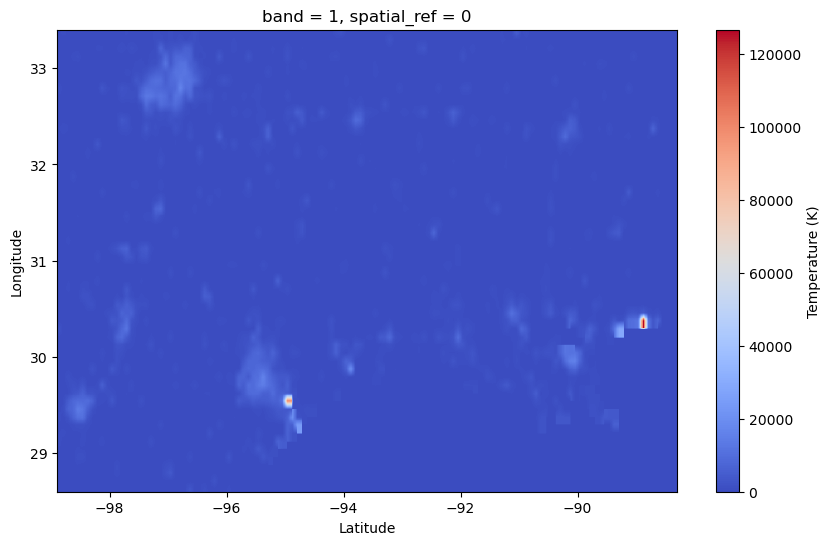

In [7]:
import matplotlib.pyplot as plt
# Define your latitude and longitude bounds
lat_min, lat_max = 28.6, 33.4  # Example latitude range
lon_min, lon_max = -98.9, -88.3  # Example longitude range

# # Select one hour of temperature data (e.g., the first timestamp)
# hour_index = 1  # Change this to select a different hour if desired
# temperature_data = filtered_ds_month['NO2'].isel(time=hour_index)

# Plot the data with switched axes
plt.figure(figsize=(10, 6))

# Plot with latitude on x-axis and longitude on y-axis
road_dens_regrid['road_density'].plot(
    cmap="coolwarm",  # Colormap for temperature visualization
    cbar_kwargs={'label': 'Temperature (K)'}  # Add color bar label
)

# Update axis labels
plt.xlabel("Latitude")
plt.ylabel("Longitude")

plt.show()